In [1]:
import glob
import numpy as np
from skimage import io
from skimage.transform import rescale
import re
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from math import sqrt
from skimage.filters import threshold_otsu
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
def get_data():
    files = glob.glob('data/hiragana73/*/*.png')
    m = len(files)
    print('Found %d files.' %m)
    
    return files

In [3]:
def create_data_array(files):
    X = np.array([io.imread(file, as_gray=True) for file in files])
    print('Data array created.')

    return X

In [4]:
def create_target_array(files):
    char_codes = files
    
    # Extract unicode from filepath
    i = 0
    for char_code in char_codes:
        code = re.search(r'[0-9]{3}[0-9A-F]', char_code)
        char_codes[i] = code.group(0)
        i += 1
        
    # Convert unicode to hiragana
    for i in range(len(char_codes)):
        char_codes[i] = chr(int(char_codes[i], 16))
        
    y = np.asarray(char_codes)
    
    # Encode to integers
    # (neural net can't train on strings)
    encoder = preprocessing.LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    
    print('Target array created.')
    
    return y

In [5]:
def reduce_dataset(X, y, reduced_size):
    '''
    Returns a stratified subsample of the dataset
    X, y reduced in size by (1 - reduced size).
    Can be used to save CPU time if you only need to
    perform quick experiments on a smaller dataset.
    '''
    
    X_discard, X, y_discard, y = train_test_split(X, y, test_size=reduced_size, stratify=y)
    print('Reduced dataset to %d%% of original size.' %(reduced_size*100))
    
    return X, y

In [6]:
def clean_data(X):
    # Rescaled images need new array
    m = X.shape[0] # Number of examples
    rescale_factor = 0.5
    image_side_new = int(X.shape[1] * rescale_factor)
    X_new = np.zeros(shape=(m, image_side_new, image_side_new))
    
    # Rescale and binarise (make black-and-white)
    for i in range(m):
        image = X[i]
        image = rescale(image, scale=rescale_factor)
        thresh = threshold_otsu(image)
        image = image > thresh
        X_new[i] = image        
    
    print('Data cleaned.')
    
    return X_new

In [7]:
def train_and_test(X, y, n_folds, n_epochs):
    print('Train and test classifier using %d folds...' %(n_folds))

    # Calculate some numbers needed for neural net
    image_shape = X.shape[1:] # image dimensions, e.g. (25, 25)
    n_feaures = np.prod(X.shape[1:]) # number of pixels in an image
    n_classes = len(set(y))
    
    # Use geometric mean of input and output layers
    # for hidden layer size
    hidden_layer_size = int(sqrt(n_feaures*n_classes))

    # Create empty arrays to save training and testing scores
    train_scores = np.zeros(shape=(n_folds, n_epochs))
    test_scores = np.zeros(shape=(n_folds, n_epochs))
    
    # k-fold cross validation
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    # Loop through folds
    k=1
    for i_train, i_test in  kfold.split(X, y):
        print('  Fold %d/%d... ' %(k, n_folds), end='')
  
        # Select train and test data for this fold
        X_train, y_train = X[i_train], y[i_train]
        X_test, y_test = X[i_test], y[i_test]

        # Define and compile neural net model (has to be done anew for each fold)
        model = keras.Sequential([
            keras.layers.Flatten(input_shape=image_shape),
            keras.layers.Dense(hidden_layer_size, activation='relu'),
            keras.layers.Dense(n_classes)
        ])
        
        model.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])
        
        # Train over n_epochs
        history = model.fit(X_train, y_train, epochs=n_epochs,
                            verbose=0, validation_data=(X_test, y_test))
        
        # Save scores for all epochs for this fold
        train_scores[k-1, :] = history.history['accuracy']
        test_scores[k-1, :] = history.history['val_accuracy']
        
        print('done.')
        k += 1
    
    return train_scores, test_scores

In [8]:
def evaluate(train_scores, test_scores):
    print('Classifier performance:')
    
    # Calculate average accuracies with uncertainties
    train_acc_means = np.mean(train_scores, axis=0)
    train_acc_errs = 2*np.std(train_scores, axis=0)
    test_acc_means = np.mean(test_scores, axis=0)
    test_acc_errs = 2*np.std(test_scores, axis=0)
    
    # Create array of epoch numbers for x-axis values
    n_epochs = train_scores.shape[1]
    epochs = np.arange(start=1, stop=n_epochs+1)
    
    # Plot learning curves
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc_means, 'r-', label='Train')
    plt.fill_between(epochs,
                     train_acc_means+train_acc_errs,
                     train_acc_means-train_acc_errs,
                     color='red', alpha=0.2)
    plt.plot(epochs, test_acc_means, 'b-', label='Test')
    plt.fill_between(epochs,
                     test_acc_means+test_acc_errs,
                     test_acc_means-test_acc_errs,
                     color='blue', alpha=0.2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (±2σ shaded regions)', fontsize=12)
    plt.xlim(epochs[0], epochs[-1])
    plt.legend(loc='lower right', fontsize=12)
    plt.title('Epoch-wise learning curves', fontsize=16)
    plt.show()
    
    # Final results (after n_epochs)
    print('Final results ± 2σ:')
    print('    train accuracy: (%.2f ± %.2f)%%,'
          %(train_acc_means[-1]*100, train_acc_errs[-1]*100))
    print('    test accuracy: (%.2f ± %.2f)%%.\n'
          %(test_acc_means[-1]*100, test_acc_errs[-1]*100))

In [9]:
def run():
    files = get_data()
    X = create_data_array(files)
    y = create_target_array(files)
    #X, y = reduce_dataset(X, y, reduced_size=0.1)
    X = clean_data(X)
    train_scores, test_scores = train_and_test(X, y, n_folds=5, n_epochs=10)
    evaluate(train_scores, test_scores)

Found 80000 files.
Data array created.
Target array created.
Data cleaned.
Train and test classifier using 5 folds...
  Fold 1/5... done.
  Fold 2/5... done.
  Fold 3/5... done.
  Fold 4/5... done.
  Fold 5/5... done.
Classifier performance:


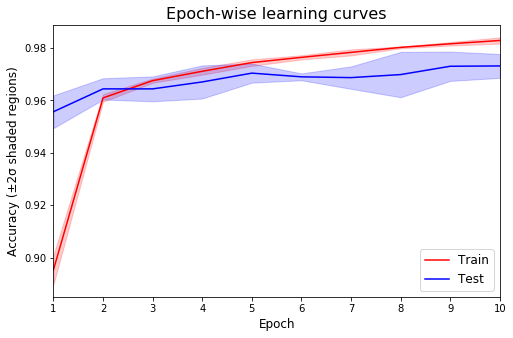

Final results ± 2σ:
    train accuracy: (98.29 ± 0.12)%,
    test accuracy: (97.32 ± 0.46)%.



In [10]:
run()

We see that the train results are worse than the test results in the first epoch, and sometimes in the next few epochs. This is expected behaviour:

> ... the training loss is the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss